#1 - Implementing the model





In [232]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from fastai.data.external import untar_data, URLs
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [233]:
!pip install fastai --upgrade

Initial Working Directory: C:\Users\dimit\Desktop\dm_ai_tumor_segmentation\data\patients\labels


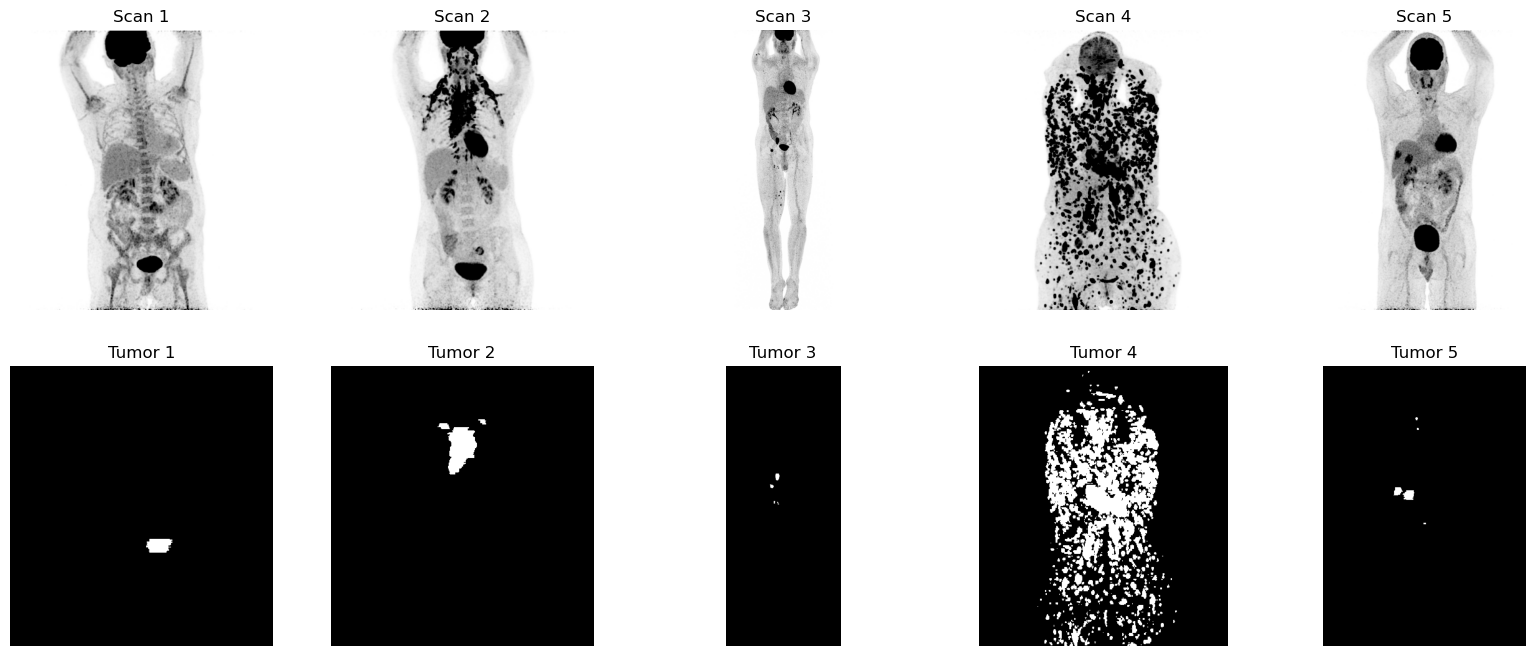

In [234]:
import os

current_directory = os.getcwd()
print("Initial Working Directory:", current_directory)

#CHANGE TO YOUR DIRECTORY
image_path = r'C:\Users\dimit\Desktop\dm_ai_tumor_segmentation\data\patients\imgs'
segmentation_path =r'C:\Users\dimit\Desktop\dm_ai_tumor_segmentation\data\patients\labels'


    
image_files = sorted(os.listdir(image_path))[20:25]
segmentation_files = sorted(os.listdir(segmentation_path))[20:25]
#first to train on small number to see if all works
train_paths = sorted(os.listdir(image_path))[:100]
val_paths = sorted(os.listdir(image_path))[100:]
# Iterate over the first five files and display the images and segmentations
i = 1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for image_file, segmentation_file in zip(image_files, segmentation_files):
    image_file_path = os.path.join(image_path, image_file)
    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)

    # Load and display the image
    img = Image.open(image_file_path)
    plt.subplot(2, 5, image_files.index(image_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Scan {i}')

    # Load and display the segmentation mask
    seg_mask = Image.open(segmentation_file_path).convert("L")
    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)
    plt.imshow(seg_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Tumor {i}')
    
    i +=1
    
plt.show()


Using the U-net approach, read about it more below and in other references. It's a personal favorite for segmentation.
Reference:

- Deep Residual Learning for Image Recognition- https://arxiv.org/pdf/1512.03385.pdf

In [235]:
class TumorDataset(Dataset):
    def __init__(self, image_dir, segmentation_dir, transform=None):
        self.image_dir = image_dir
        self.segmentation_dir = segmentation_dir
        self.transform = transform

        self.image_filenames = sorted(os.listdir(image_dir))
        self.segmentation_filenames = sorted(os.listdir(segmentation_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        segmentation_path = os.path.join(self.segmentation_dir, self.segmentation_filenames[idx])

        image = Image.open(image_path).convert('L')  # Convert to grayscale
        segmentation = Image.open(segmentation_path).convert('L')

        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        return {'ct_scan': image, 'tumor_mask': segmentation}

def custom_collate(batch):
    # Resize images and masks to a common size
    batch_size = len(batch)
    max_height = max(item['ct_scan'].shape[1] for item in batch)
    max_width = max(item['ct_scan'].shape[2] for item in batch)

    # Pad images and masks to the maximum size
    padded_images = [torch.nn.functional.pad(item['ct_scan'], pad=(0, max_width - item['ct_scan'].shape[2], 0, max_height - item['ct_scan'].shape[1])) for item in batch]
    padded_masks = [torch.nn.functional.pad(item['tumor_mask'], pad=(0, max_width - item['tumor_mask'].shape[2], 0, max_height - item['tumor_mask'].shape[1])) for item in batch]

    # Stack padded images and masks
    stacked_images = torch.stack(padded_images)
    stacked_masks = torch.stack(padded_masks)

    return {'ct_scan': stacked_images, 'tumor_mask': stacked_masks}

# Define your data transformation (adjust as needed)
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Define your dataset instance
dataset = TumorDataset(image_dir=image_path, segmentation_dir=segmentation_path, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define batch size
batch_size = 1  # Adjust as needed

# Create data loaders with the custom collate function
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=custom_collate)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=custom_collate)


In [236]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
        ]
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            x_clone = x.clone()
            return torch.cat([self.residual(x_clone), self.model(x)], 1)


class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return torch.tanh(self.model(x)) * 0.5 + 0.5


##1.4- Discriminator (with Dilated Convolutions)

References:

- Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). Image-to-Image Translation with Conditional Adversarial Networks. https://arxiv.org/pdf/1611.07004.pdf

- Yu, F., & Koltun, V. (2016). Multi-Scale Context Aggregation by Dilated Convolutions. https://arxiv.org/pdf/1511.07122.pdf


In [237]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, dilation_rate=1):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, dilation=dilation_rate),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class FinalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation_rate=1):
        super(FinalConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, dilation=dilation_rate)

    def forward(self, x):
        return self.conv(x)


class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3, dilation_rate=1):
        super(PatchDiscriminator, self).__init__()
        model = [ConvLayer(input_c, num_filters, stride=2)]
        model += [ConvLayer(num_filters * 2 ** i, num_filters * 2 ** (i + 1),
                            stride=1 if i == (n_down-1) else 2)
                  for i in range(n_down)]
        model += [FinalConvLayer(num_filters * 2 ** n_down, 1, stride=1)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [238]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): ConvLayer(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvLayer(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvLayer(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): ConvLayer(
      (conv): S

In [239]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

##1.5- GAN Loss (Addressing Color Imbalance in Image Colorization with Weighted Loss Function)


 Reference:
- Zhang, R., Isola, P., Efros, A. A. (2016). Colorful Image Colorization- https://arxiv.org/pdf/1603.08511.pdf

In [240]:
#enhanced loss
class GANLossWeighted(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0, num_classes=313, rebalance_factor=0.5):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.num_classes = num_classes
        self.rebalance_factor = rebalance_factor

        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss(reduction='none')
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss(reduction='none')

        class_distribution = np.load('prior_probs.npy')
        class_weights = 1 / (np.log(self.rebalance_factor + class_distribution))
        self.register_buffer('class_weights', torch.tensor(class_weights, dtype=torch.float))

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real, use_class_weights=False):
        labels = self.get_labels(preds, target_is_real)
        losses = self.loss(preds, labels)

        if use_class_weights:
            weights = self.class_weights[labels.long()]
            weighted_losses = losses * weights
            return weighted_losses.mean()
        else:
            return losses.mean()



In [241]:
#stanbdard loss

class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article

In [242]:
def init_weights(net, init='norm', gain=0.02, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='norm', gain=0.02):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model


##1.6- Attention Layer


References:

- Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention- https://arxiv.org/pdf/1502.03044.pdf
- Attention Is All You Need- https://arxiv.org/pdf/1706.03762.pdf.

In [243]:

class SelfAttention(nn.Module):
    def __init__(self, in_dim, activation):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim
        self.activation = activation

        # Ensure the output channel of the convolutional layers are at least 1
        out_c = max(1, in_dim // 8)

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=out_c, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=out_c, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma*out + x
        return out



In [244]:
import torch.nn.functional as F

class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=1, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=2, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.ct_scan = data['ct_scan'].to(self.device)
        self.tumor_mask = data['tumor_mask'].to(self.device)

    def forward(self):
        self.predicted_tumor_mask = torch.sigmoid(self.net_G(self.ct_scan))

    def backward_D(self):
        fake_image = torch.cat([self.ct_scan, self.predicted_tumor_mask], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.ct_scan, self.tumor_mask], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.ct_scan, self.predicted_tumor_mask], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.predicted_tumor_mask, self.tumor_mask) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()



The MeasureClass class is a utility class for computing and tracking the average of a value over multiple iterations. It keeps track of the count, sum, and average of the values. The reset method resets the meter, while the update method updates the meter with a new value and count.



In [245]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [246]:
from torch.utils.tensorboard import SummaryWriter

class MeasureClass:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = MeasureClass()
    loss_D_real = MeasureClass()
    loss_D = MeasureClass()
    loss_G_GAN = MeasureClass()
    loss_G_L1 = MeasureClass()
    loss_G = MeasureClass()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count, writer, step):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        writer.add_scalar(loss_name, loss_meter.avg, step)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict, step, writer):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        writer.add_scalar(loss_name, loss_meter.avg, step)

##1.8- Training function


In [247]:
def train_model_with_weighted_gan_loss(model, train_dl, val_dl, epochs, display_every=200):
    val_data = next(iter(val_dl))
    writer = SummaryWriter()
    step = 0

    for epoch in range(1, epochs + 1):
        loss_meter_dict = create_loss_meters()
        i = 0

        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['ct_scan'].size(0), writer=writer, step=step)
            i += 1
            step += 1

            if i % display_every == 0:
                print(f"\nEpoch {epoch}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict, step, writer)
                visualize(model, val_data, save=False)

        epoch_filename = f"model_epoch{epoch}_fulldataset.pt"
        torch.save(model.state_dict(), epoch_filename)
        print(f"Saved weights of epoch {epoch} to {epoch_filename}")

    writer.close()

# Assuming train_dl and val_dl are your training and validation data loaders
model = MainModel()
train_model_with_weighted_gan_loss(model, train_dl, val_dl, epochs=100)


model initialized with norm initialization
model initialized with norm initialization


RuntimeError: DataLoader worker (pid(s) 27264) exited unexpectedly

#2-Transfer Learning

##2.1- Using a new generator
We'll use fastai library's Dynamic U-Net module to easily build a U-Net with a ResNet backbone

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(pretrained=True), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

##2.2 Pretraining the generator

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for e in range(epochs):
        loss_meter = MeasureClass()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 5)

In [ ]:
torch.save(net_G.state_dict(), "res18-unet.pt")


##2.3- Final training

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(f"res18_unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("model_epoch20.pt", map_location=device))
train_model(model, train_dl, 10)

# 3- Test the model

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_weights.pt", map_location=device))